In [65]:
# Exercise Apply Naive Bayes on Amazon reviews dataset

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [66]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'G:\machine_learning\NAIVE_BAYES\database3.sqlite')
 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,good,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [67]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [68]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [69]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [70]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [71]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [72]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [73]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [74]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [75]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'do', 've', 'don', 'when', 'and', 'there', "haven't", 'ours', 'should', "mightn't", 'her', 'where', 'between', 'hasn', 'doesn', 'a', 'mustn', 'does', 'through', 'you', 'their', 'is', 'them', 'who', 'yours', 'm', 'am', 'ma', 'that', 'ourselves', "mustn't", 'his', 'or', 'too', 't', 'at', 'hers', 'if', 'aren', 'more', 'few', 'needn', "won't", 'about', 'shouldn', "doesn't", 'on', 'for', 'against', 'yourself', 'again', 'mightn', 'weren', 'not', 'how', 'such', 'yourselves', 'out', 'our', 'as', 'itself', "didn't", 'being', 'no', 'by', 'theirs', "couldn't", 'll', 'myself', 'themselves', 'didn', 'most', 'i', 'from', 'why', "wouldn't", 'both', 'then', 'own', 'my', 'this', 'o', 'the', 'nor', 'whom', 'it', "you'd", 'below', 'over', 'an', 'above', 'before', 'himself', 'very', 'just', "shouldn't", "isn't", 'are', 'until', 'any', 'with', 'what', "shan't", "that'll", 'she', 'be', 'each', 'isn', "you've", 'same', 'was', 'will', 'having', 'because', 'were', 'y', "hasn't", "needn't", 'we', "aren't", 're

In [76]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final1.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final1.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [77]:
if os.path.isfile('final1.sqlite'):
    conn = sqlite3.connect('final1.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# randomly generate data and sort in ascending order

In [107]:
#random_sample = final.sample(n = 6000)
#random_sample.shape
#random_sample = random_sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_sample = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_60000 = sorted_sample.iloc[0:100000]
final.shape
y = sample_60000['Score']

In [108]:
# sort the data in 60:20:20 ratio
x_train_size = int(len(sample_60000)*.60)
y_size  = int(len(y)*.60)

# split into Train and Test sets    
x_train = sample_60000[0:x_train_size]
x_test = sample_60000[x_train_size:len(sample_60000)]

print("total data",len(sample_60000))
print("x_train data",len(x_train))
#print("x_test data",len(x_test))

y_train = y[0:y_size]
y_test = y[y_size:len(y)]


print("total output data",len(y))
print("total y_train data",len(y_train))
#print("total y_test data",len(y_test))

x_tr_size = int(len(x_test)*.50)
y_tr_size = int(len(y_test)*.50)

x_cv = x_test[0:x_tr_size]
x_ts = x_test[x_tr_size:len(x_test)]

#print("total data",x_tr_size)
print("x_cv data",len(x_cv))
print("x_ts data",len(x_ts))

y_cv = y[0:y_tr_size]
y_ts = y[y_tr_size:len(y_test)]

#print("total data",y_tr_size)
print("y_cv data",len(y_cv))
print("y_ts data",len(y_ts))




total data 100000
x_train data 60000
total output data 100000
total y_train data 60000
x_cv data 20000
x_ts data 20000
y_cv data 20000
y_ts data 20000


# [7.2.2] Bag of Words (BoW)

In [109]:
#BoW
count_vect = CountVectorizer(ngram_range=(1, 2),max_features=2000,min_df=10) #in scikit-learn
x_tr_final_counts = count_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts = count_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts = count_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts))
print("the shape of out text BOW vectorizer ",x_tr_final_counts.get_shape())
print("the number of unique words ", x_tr_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts))
print("the shape of out text BOW vectorizer ",x_cv_final_counts.get_shape())
print("the number of unique words ", x_cv_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts))
print("the shape of out text BOW vectorizer ",x_ts_final_counts.get_shape())
print("the number of unique words ", x_ts_final_counts.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 2000)
the number of unique words  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 2000)
the number of unique words  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 2000)
the number of unique words  2000


Best alpha is:- 50.0


No handles with labels found to put in legend.


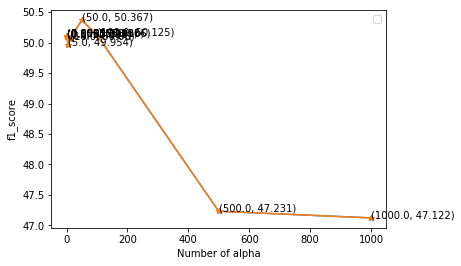

In [110]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
    
    
alpha_values = np.arange(14)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
lst = np.array([1000,500,100,50,10,5,1,.1,.5,.01,.05,.001,.005,0.0001])

ap = len(lst)
for i in range(ap):
    
    mnb = MultinomialNB(alpha = lst[i])
    mnb.fit(x_tr_final_counts, y_train)
    
    # predict the response on the crossvalidation train
    pred = mnb.predict(x_cv_final_counts)

    # evaluate CV accuracy
    acc[i] = f1_score(y_cv, pred, average='macro') * float(100)
        #print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    #error[i] = 100-acc[i]
           
  #  optimal_k = int(min(error))
  #  print('\nThe optimal number of neighbors is %d.' % optimal_k)

    
    #Generate plot
    
d = acc.max()

i = np.where(acc == d)
i = i[0][0]
best_alpha = float(lst[i])
print("Best alpha is:-",best_alpha)
  #  plt.title('k-NN Varying number of neighbors')
plt.plot(lst, acc, marker = '*')

for xy in zip(lst, np.round(acc,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.plot(lst, acc, marker = '*')
#plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of alpha')
plt.ylabel('f1_score')
plt.show()
    


In [111]:
# ============================== Naive Bayes  = best_alpha ===============================================


mnb = MultinomialNB(alpha=best_alpha)

# fitting the model
mnb.fit(x_tr_final_counts, y_train)

# predict the response
pred = mnb.predict(x_ts_final_counts)

# evaluate accuracy
f1_score_bowT = f1_score(y_ts, pred, average='macro') * float(100)
f1_score_bowT_alpha = best_alpha
print('\nThe f1_score of the Naive Bayes classifier of best_alpha = %f is %f%%' % (best_alpha, f1_score_bowT))


The f1_score of the Naive Bayes classifier of best_alpha = 50.000000 is 49.878292%


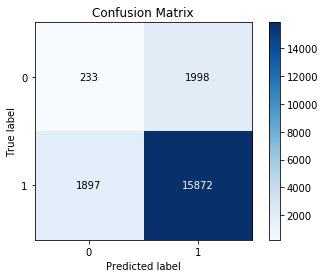

In [112]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


In [113]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.11      0.10      0.11      2231
          1       0.89      0.89      0.89     17769

avg / total       0.80      0.81      0.80     20000



Terminology

true positives (TP): We predicted +ve review, and review is also +ve.
true negatives (TN): We predicted -ve, and review is also -ve.
false positives (FP): We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")
false negatives (FN): We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1998/2231 = .89


In [114]:
# FPR for bowt
bowt_FPR = .89

# Top 10 features

In [115]:
# To get all the features name 
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['avail', 'avail amazon', 'averag', 'avoid', 'aw', 'awar', 'away', 'awesom', 'awhil', 'babi']


In [116]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = mnb.feature_count_
feat_count.shape

(2, 2000)

In [117]:
# Number of samples encountered for each class during fitting

mnb.class_count_

array([ 6853., 53147.])

In [118]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = mnb.feature_log_prob_
log_prob

array([[-7.45222902, -8.62574262, -7.48897856, ..., -8.69473549,
        -8.1982986 , -7.92429663],
       [-7.04423544, -8.59841724, -7.00470933, ..., -8.08182791,
        -7.30519568, -9.02432101]])

In [119]:
feature_prob = pd.DataFrame(log_prob, columns = features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(2000, 2)

In [120]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -4.430046
like      -4.527517
product   -4.624184
one       -4.920334
flavor    -5.029801
would     -5.092056
tri       -5.104296
good      -5.204743
tea       -5.378603
buy       -5.385758
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -4.443833
tast      -4.465797
tea       -4.584119
good      -4.615069
flavor    -4.642516
great     -4.647451
love      -4.729386
use       -4.771474
one       -4.806507
product   -4.841258
Name: 1, dtype: float64


# [7.2.5] TF-IDF

In [121]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2),max_features=2000,min_df=10)
x_tr_final_counts = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts = tf_idf_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts = tf_idf_vect.transform(x_ts['CleanedText'].values)

print("the type of count vectorizer ",type(x_tr_final_counts))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts))
print("the shape of out text TFIDF vectorizer ",x_cv_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 2000)
the number of unique words including both unigrams and bigrams  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 2000)
the number of unique words including both unigrams and bigrams  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 2000)
the number of unique words including both unigrams and bigrams  2000


Best alpha is:- 0.01


No handles with labels found to put in legend.


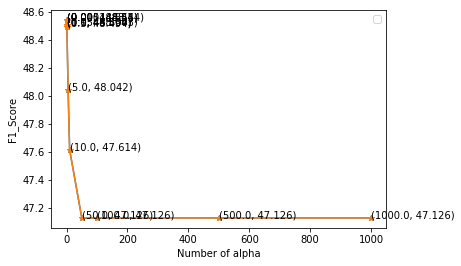

In [122]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
    
    
alpha_values = np.arange(14)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
lst = np.array([1000,500,100,50,10,5,1,.1,.5,.01,.05,.001,.005,0.0001])

ap = len(lst)
for i in range(ap):
    
    mnb = MultinomialNB(alpha = lst[i])
    mnb.fit(x_tr_final_counts, y_train)
    
    # predict the response on the crossvalidation train
    pred = mnb.predict(x_cv_final_counts)

    # evaluate CV accuracy
    acc[i] = f1_score(y_cv, pred, average='macro') * float(100)
        #print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    #error[i] = 100-acc[i]
           
  #  optimal_k = int(min(error))
  #  print('\nThe optimal number of neighbors is %d.' % optimal_k)

    
    #Generate plot
    
d = acc.max()

i = np.where(acc == d)
i = i[0][0]
best_alpha = float(lst[i])
print("Best alpha is:-",best_alpha)
  #  plt.title('k-NN Varying number of neighbors')
plt.plot(lst, acc, marker = '*')

for xy in zip(lst, np.round(acc,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.plot(lst, acc, marker = '*')
#plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of alpha')
plt.ylabel('F1_Score')
plt.show()
    


In [123]:
# ============================== Naive Bayes = best_alpha ===============================================


mnb = MultinomialNB(alpha=best_alpha)

# fitting the model
mnb.fit(x_tr_final_counts, y_train)

# predict the response
pred = mnb.predict(x_ts_final_counts)

# evaluate f1_score
f1_score_tfidf = f1_score(y_ts, pred, average='macro') * float(100)
f1_score_tfidf_alpha = best_alpha
print('\nThe f1_score of the Naive Bayes classifier of best_alpha = %f is %f%%' % (best_alpha, f1_score_tfidf))


The f1_score of the Naive Bayes classifier of best_alpha = 0.010000 is 48.192288%


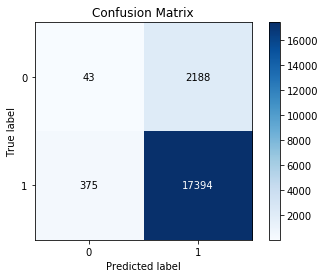

In [125]:
skplt.plot_confusion_matrix(y_ts ,pred)

In [126]:
#classification report

print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.10      0.02      0.03      2231
          1       0.89      0.98      0.93     17769

avg / total       0.80      0.87      0.83     20000



Terminology

true positives (TP): We predicted +ve review, and review is also +ve. true negatives (TN): We predicted -ve, and review is also -ve. false positives (FP): We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.") false negatives (FN): We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2188/2231 = .98

In [127]:
#FPR for tfidf
tfidf_FPR = .98

# Top 10 features

In [128]:
# To get all the features name 
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['avail', 'avail amazon', 'averag', 'avoid', 'aw', 'awar', 'away', 'awesom', 'awhil', 'babi']


In [129]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = mnb.feature_count_
feat_count.shape

(2, 2000)

In [130]:
# Number of samples encountered for each class during fitting

mnb.class_count_

array([ 6853., 53147.])

In [131]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = mnb.feature_log_prob_
log_prob

array([[ -7.37946468,  -9.81426237,  -7.38675871, ..., -10.20811146,
         -8.45413408,  -7.68839514],
       [ -6.88155419,  -8.16472337,  -6.80145897, ...,  -7.66013923,
         -6.97293912,  -9.05334727]])

In [132]:
feature_prob = pd.DataFrame(log_prob, columns = features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(2000, 2)

In [133]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -4.680602
product   -4.774609
like      -4.801611
would     -5.123808
one       -5.153619
flavor    -5.215313
order     -5.276224
tri       -5.304676
buy       -5.308975
box       -5.419335
Name: 0, dtype: float64


 Top 10 Positive Features:-
 tea       -4.941942
great     -4.953177
tast      -5.029164
love      -5.029358
good      -5.035356
like      -5.061389
flavor    -5.143643
product   -5.182316
use       -5.241207
one       -5.324948
Name: 1, dtype: float64


In [134]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","hyperparameter(alpha)","F1_Score","FPR"]
x.add_row(["BOW",f1_score_bowT_alpha,f1_score_bowT,bowt_FPR])
x.add_row(["TF-IDF",f1_score_tfidf_alpha,f1_score_tfidf,tfidf_FPR])
print(x)

+------------+-----------------------+-------------------+------+
| Vectorizer | hyperparameter(alpha) |      F1_Score     | FPR  |
+------------+-----------------------+-------------------+------+
|    BOW     |          50.0         | 49.87829207532883 | 0.89 |
|   TF-IDF   |          0.01         | 48.19228835440566 | 0.98 |
+------------+-----------------------+-------------------+------+


as per the above table, we will consider bow vectorizer for classification of positive and negative points because FPR of 
BOW(.89) is less than TF-IDF(.98) and alpha of BOW(50) is greater than TFIDF(.01) and it is well fit. it is neither 
underfit nor overfit.  